## Time series task typology

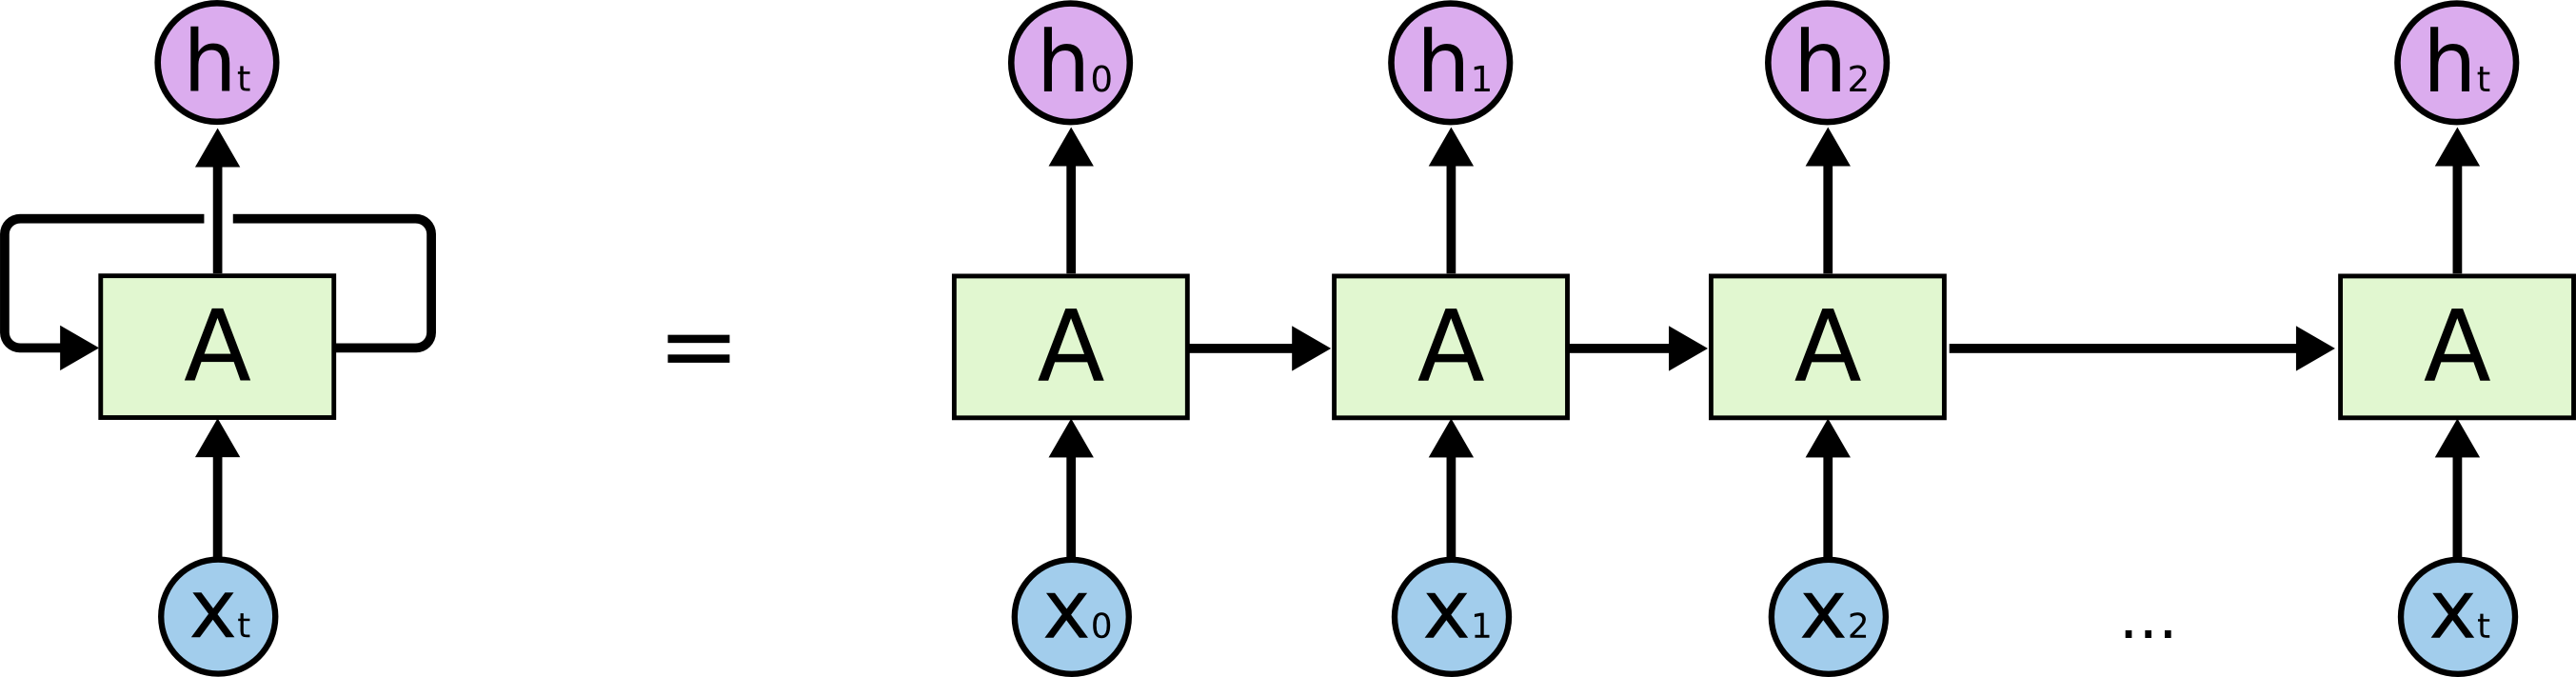

In [1]:
from IPython.display import Image
Image(filename='imgs/RNN-unrolled.png', width=800)

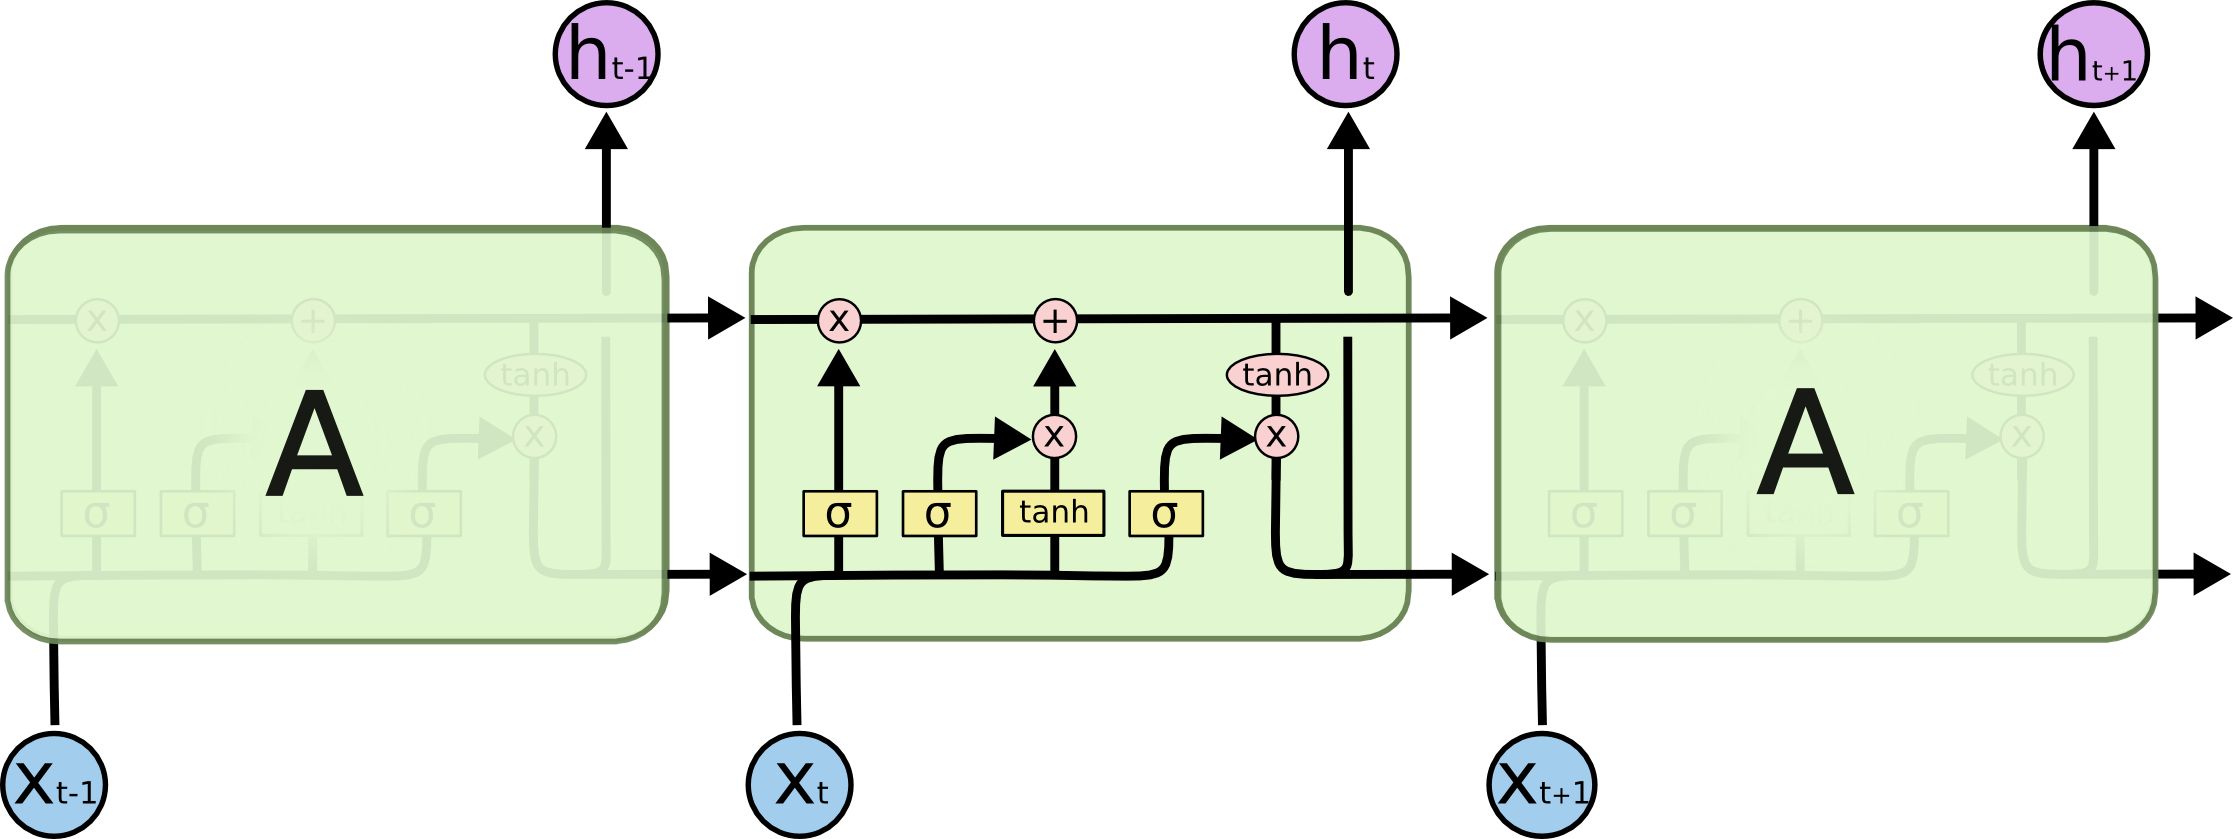

In [2]:
Image(filename='imgs/LSTM3-chain.png', width=800)

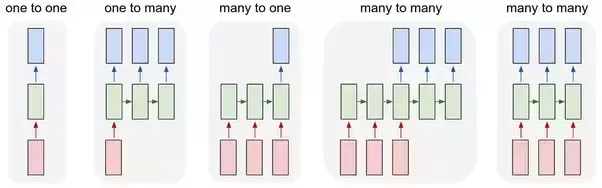

In [1]:
from IPython.display import Image
Image(filename='imgs/lstm-types.jpg', width=800)

- Each rectangle is a vector 
-  arrows represent functions (e.g. matrix multiply). 
- Input vectors are in red
- Output vectors are in blue
- Green vectors hold the RNN's state (more on this soon). 

### **Input data**

must **always** be of shape `[nb_samples, nb_timesteps_in, nb_features_in]`

- if `nb_features`>1 then we are dealing about multisignal time series

### Task typology

**one-to-one**: From fixed-sized input to fixed-sized output (e.g. image classification).
- **input_data**: `[nb_samples, 1, nb_features_in]`
- **output_data**: `[nb_samples, nb_features_out]`

**one-to-many**: Sequence output (e.g. image captioning takes an iFage and outputs a sentence of words). 
- **input_data**: `[nb_samples, 1, nb_features_in]`
- **output_data**: `[nb_samples, nb_timesteps_out, nb_features_out]`

**many-to-one**: Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment).
- **input_data**: `[nb_samples, nb_timesteps_in, nb_features_in]`
- **output_data**: `[nb_samples, nb_features_out]`

**many-to-many**: Sequence input and sequence output (e.g. Machine Translation: an RNN reads a sentence in English and then outputs a sentence in French). 
- **input_data**: `[nb_samples, nb_timesteps_in, nb_features_in]`
- **output_data**: `[nb_samples, nb_timesteps_out, nb_features_out]`

**many-to-many**: Synced sequence input and output (e.g. video classification where we wish to label each frame of the video). Notice that in every case are no pre-specified constraints on the lengths sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like.
- **input_data**: `[nb_samples, nb_timesteps_in, nb_features_in]`
- **output_data**: `[nb_samples, nb_timesteps_out, nb_features_out]`



## Original signal

1.9.0


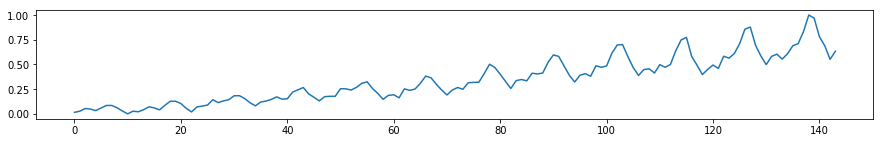

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Activation, RepeatVector
import tensorflow as tf
print tf.__version__
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

dataset = pd.read_csv('data/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

plt.figure(figsize=(15,2))
plt.plot(dataset)




## Timeseries dataset creation

In [154]:
def timeseries_as_one2one(t, timelag=1):
    assert timelag>0, "timelag must be >0"
    X = t[:-timelag].reshape(-1,1,1)
    y = t[timelag:].reshape(-1,1)
    return X,y

def timeseries_as_many2one(t, nb_timesteps_in, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1])
    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,1)

def timeseries_as_many2many(t, nb_timesteps_in, nb_timesteps_out, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag-nb_timesteps_out):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1:i+nb_timesteps_in+timelag-1+nb_timesteps_out])

    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,nb_timesteps_out,1)


### one2one

In [155]:
X,y = timeseries_as_one2one(dataset, timelag=1)
print "Xy shapes", X.shape, y.shape
print "original signal", dataset[:10].flatten()
print "input data"
for i in range(3):
    print X[i].flatten()
print "output data", y[:3].flatten()

Xy shapes (143, 1, 1) (143, 1)
original signal [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
input data
[0.01544401]
[0.02702703]
[0.05405405]
output data [0.02702703 0.05405405 0.04826255]


### many2one

In [156]:
X,y = timeseries_as_many2one(dataset, nb_timesteps_in=4, timelag=1)
print "Xy shapes", X.shape, y.shape
print "original signal", dataset[:10].flatten()
print "input data"
for i in range(3):
    print X[i].flatten()
print "output data", y[:3].flatten()

Xy shapes (139, 4, 1) (139, 1)
original signal [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
input data
[0.01544401 0.02702703 0.05405405 0.04826255]
[0.02702703 0.05405405 0.04826255 0.03281853]
[0.05405405 0.04826255 0.03281853 0.05984557]
output data [0.03281853 0.05984557 0.08494207]


### many2many

In [157]:
X,y = timeseries_as_many2many(dataset, nb_timesteps_in=4, nb_timesteps_out=2, timelag=1)
print "Xy shapes", X.shape, y.shape
print "original signal", dataset[:10].flatten()
print "input data"
for i in range(3):
    print X[i].flatten()
print "output data"
for i in range(3):
    print y[i].flatten()


Xy shapes (137, 4, 1) (137, 2, 1)
original signal [0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
input data
[0.01544401 0.02702703 0.05405405 0.04826255]
[0.02702703 0.05405405 0.04826255 0.03281853]
[0.05405405 0.04826255 0.03281853 0.05984557]
output data
[0.03281853 0.05984557]
[0.05984557 0.08494207]
[0.08494207 0.08494207]


# LSTMs

## for one2one

In [158]:
X,y = timeseries_as_one2one(dataset, timelag=1)
X.shape, y.shape

((143, 1, 1), (143, 1))

In [159]:
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((95, 1, 1), (48, 1, 1), (95, 1), (48, 1))

In [160]:
def get_one2one_single_layer_LSTM(n_neurons):
    # create LSTM
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(1, 1), recurrent_activation="sigmoid"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mape"])
    return model

In [161]:
model = get_one2one_single_layer_LSTM(n_neurons=10)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [162]:
model.fit(Xtr, ytr, epochs=150, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 95 samples, validate on 48 samples
Epoch 1/150
95/95 [==============================] - 1s 14ms/step - loss: 0.0422 - mean_absolute_percentage_error: 204152.6616 - val_loss: 0.2393 - val_mean_absolute_percentage_error: 78.6704
Epoch 2/150
95/95 [==============================] - 0s 589us/step - loss: 0.0352 - mean_absolute_percentage_error: 301733.9210 - val_loss: 0.2147 - val_mean_absolute_percentage_error: 74.0628
Epoch 3/150
95/95 [==============================] - 0s 567us/step - loss: 0.0290 - mean_absolute_percentage_error: 563002.6304 - val_loss: 0.1915 - val_mean_absolute_percentage_error: 69.4694
Epoch 4/150
95/95 [==============================] - 0s 617us/step - loss: 0.0236 - mean_absolute_percentage_error: 726570.6989 - val_loss: 0.1700 - val_mean_absolute_percentage_error: 64.9477
Epoch 5/150
95/95 [==============================] - 0s 547us/step - loss: 0.0195 - mean_absolute_percentage_error: 816754.2434 - val_loss: 0.1501 - val_mean_absolute_percentage_error: 

Epoch 43/150
95/95 [==============================] - 0s 546us/step - loss: 0.0031 - mean_absolute_percentage_error: 998557.9709 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 16.6296
Epoch 44/150
95/95 [==============================] - 0s 624us/step - loss: 0.0030 - mean_absolute_percentage_error: 972911.8086 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 16.1186
Epoch 45/150
95/95 [==============================] - 0s 528us/step - loss: 0.0029 - mean_absolute_percentage_error: 957795.0876 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 15.6738
Epoch 46/150
95/95 [==============================] - 0s 610us/step - loss: 0.0028 - mean_absolute_percentage_error: 914736.1295 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 15.6279
Epoch 47/150
95/95 [==============================] - 0s 809us/step - loss: 0.0027 - mean_absolute_percentage_error: 882549.6934 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 15.5508
Epoch 48/150
95/95 [==========

95/95 [==============================] - 0s 465us/step - loss: 0.0020 - mean_absolute_percentage_error: 498223.5379 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 13.0883
Epoch 128/150
95/95 [==============================] - 0s 581us/step - loss: 0.0020 - mean_absolute_percentage_error: 505311.7353 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 13.0894
Epoch 129/150
95/95 [==============================] - 0s 659us/step - loss: 0.0020 - mean_absolute_percentage_error: 505721.0775 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 13.0911
Epoch 130/150
95/95 [==============================] - 0s 526us/step - loss: 0.0020 - mean_absolute_percentage_error: 526998.5334 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 13.0428
Epoch 131/150
95/95 [==============================] - 0s 488us/step - loss: 0.0020 - mean_absolute_percentage_error: 506446.6878 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 13.1006
Epoch 132/150
95/95 [==================

In [163]:
yts_preds = model.predict(Xts)
print "trend accuracy %.2f"%(np.mean( (yts_preds[1:]>yts_preds[:-1])==(yts[1:]>yts[:-1])))
yts_preds.shape

trend accuracy 0.53


(48, 1)

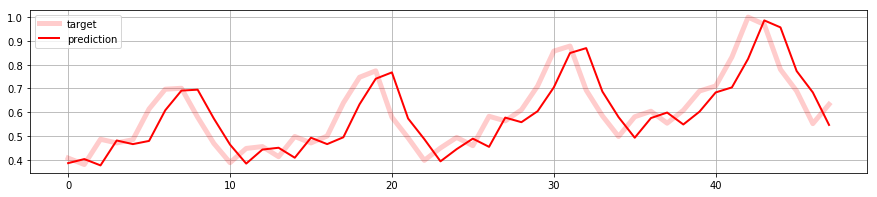

In [164]:
plt.figure(figsize=(15,3))
plt.plot(yts[:,0], color="red", alpha=.2, lw=5, label="target")
plt.plot(yts_preds[:,0], color="red", alpha=1, lw=2, label="prediction")
plt.legend()
plt.grid()

## For many2one

In [181]:
X,y = timeseries_as_many2one(dataset, nb_timesteps_in=20, timelag=1)
X.shape, y.shape

((123, 20, 1), (123, 1))

In [182]:
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((82, 20, 1), (41, 20, 1), (82, 1), (41, 1))

In [183]:
def get_many2one_single_layer_LSTM(n_neurons, nb_timesteps_in):
    # create LSTM
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(nb_timesteps_in, 1),recurrent_activation="sigmoid"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mape"])
    return model

In [184]:
model = get_many2one_single_layer_LSTM(n_neurons=30, nb_timesteps_in=X.shape[1])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
None


In [185]:
model.fit(Xtr, ytr, epochs=150, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 82 samples, validate on 41 samples
Epoch 1/150
82/82 [==============================] - 1s 17ms/step - loss: 0.0400 - mean_absolute_percentage_error: 58.4223 - val_loss: 0.0712 - val_mean_absolute_percentage_error: 33.1934
Epoch 2/150
82/82 [==============================] - 0s 4ms/step - loss: 0.0085 - mean_absolute_percentage_error: 47.0617 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 21.2782
Epoch 3/150
82/82 [==============================] - 0s 4ms/step - loss: 0.0094 - mean_absolute_percentage_error: 57.4809 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 18.1569
Epoch 4/150
82/82 [==============================] - 0s 4ms/step - loss: 0.0066 - mean_absolute_percentage_error: 34.6853 - val_loss: 0.0440 - val_mean_absolute_percentage_error: 22.9018
Epoch 5/150
82/82 [==============================] - 0s 4ms/step - loss: 0.0071 - mean_absolute_percentage_error: 33.1939 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 18.0979
Epoch 6/150
82/82 [=

Epoch 88/150
82/82 [==============================] - 0s 4ms/step - loss: 0.0018 - mean_absolute_percentage_error: 18.2218 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 10.9742
Epoch 89/150
82/82 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_absolute_percentage_error: 17.2648 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 11.0939
Epoch 90/150
82/82 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_absolute_percentage_error: 17.4381 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 11.3641
Epoch 91/150
82/82 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_percentage_error: 18.1488 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 12.6740
Epoch 92/150
82/82 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_absolute_percentage_error: 17.1215 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 12.3110
Epoch 93/150
82/82 [==============================] - 0s 4ms

In [186]:
yts_preds = model.predict(Xts)
yts_preds.shape
print "trend accuracy %.2f"%(np.mean( (yts_preds[1:]>yts_preds[:-1])==(yts[1:]>yts[:-1])))

trend accuracy 0.75


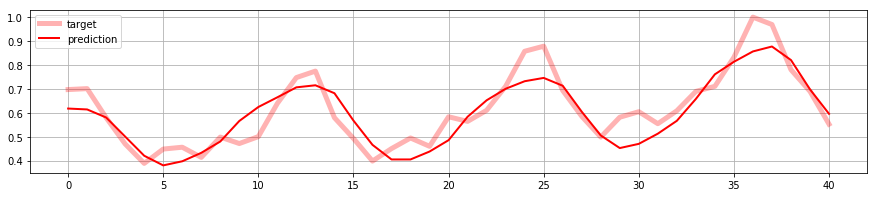

In [187]:
plt.figure(figsize=(15,3))
plt.plot(yts[:,0], color="red", alpha=.3, lw=5, label="target")
plt.plot(yts_preds[:,0], color="red", alpha=1, lw=2, label="prediction")
plt.legend()
plt.grid()

## For many2many

see https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras

In [172]:
def timeseries_as_many2many(t, nb_timesteps_in, nb_timesteps_out, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag-nb_timesteps_out):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1:i+nb_timesteps_in+timelag-1+nb_timesteps_out])

    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,nb_timesteps_out,1)




In [173]:
X,y = timeseries_as_many2many(dataset, nb_timesteps_in=30, nb_timesteps_out=5, timelag=1)
X.shape, y.shape

((108, 30, 1), (108, 5, 1))

In [174]:
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((72, 30, 1), (36, 30, 1), (72, 5, 1), (36, 5, 1))

In [175]:
from tensorflow.keras.optimizers import RMSprop

In [176]:
def get_many2many_single_layer_LSTM(n_neurons1, n_neurons2,  nb_timesteps_in, nb_timesteps_out):
    from tensorflow.keras.optimizers import RMSprop    
    
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons1, input_shape=(nb_timesteps_in, 1), 
                   recurrent_activation="sigmoid", return_sequences=False))
    model.add(RepeatVector(nb_timesteps_out))
    model.add(LSTM(n_neurons2, input_shape=(nb_timesteps_out, 1), 
                   recurrent_activation="sigmoid", return_sequences=True))
    model.add(Dense(1))
    optimizer = RMSprop(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer="rmsprop", metrics=["mape"])
    return model

In [177]:
model = get_many2many_single_layer_LSTM(n_neurons1=20, n_neurons2=50,
                                        nb_timesteps_in=X.shape[1], nb_timesteps_out=y.shape[1])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             14200     
_________________________________________________________________
dense (Dense)                (None, 5, 1)              51        
Total params: 16,011
Trainable params: 16,011
Non-trainable params: 0
_________________________________________________________________
None


In [178]:
model.fit(Xtr, ytr, epochs=300, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 72 samples, validate on 36 samples
Epoch 1/300
72/72 [==============================] - 5s 67ms/step - loss: 0.0621 - mean_absolute_percentage_error: 61.8995 - val_loss: 0.1175 - val_mean_absolute_percentage_error: 45.6619
Epoch 2/300
72/72 [==============================] - 0s 7ms/step - loss: 0.0210 - mean_absolute_percentage_error: 39.8901 - val_loss: 0.0789 - val_mean_absolute_percentage_error: 35.3306
Epoch 3/300
72/72 [==============================] - 1s 7ms/step - loss: 0.0173 - mean_absolute_percentage_error: 36.3728 - val_loss: 0.0512 - val_mean_absolute_percentage_error: 31.9015
Epoch 4/300
72/72 [==============================] - 0s 6ms/step - loss: 0.0151 - mean_absolute_percentage_error: 35.6983 - val_loss: 0.0572 - val_mean_absolute_percentage_error: 28.4236
Epoch 5/300
72/72 [==============================] - 0s 6ms/step - loss: 0.0130 - mean_absolute_percentage_error: 30.5117 - val_loss: 0.0413 - val_mean_absolute_percentage_error: 31.0742
Epoch 6/300
72/72 [=

Epoch 88/300
72/72 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_absolute_percentage_error: 23.4665 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 17.2764
Epoch 89/300
72/72 [==============================] - 1s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 21.1822 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 16.2071
Epoch 90/300
72/72 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_absolute_percentage_error: 22.1412 - val_loss: 0.0372 - val_mean_absolute_percentage_error: 32.9158
Epoch 91/300
72/72 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 21.7138 - val_loss: 0.0557 - val_mean_absolute_percentage_error: 40.5669
Epoch 92/300
72/72 [==============================] - 0s 6ms/step - loss: 0.0074 - mean_absolute_percentage_error: 24.0927 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 24.5838
Epoch 93/300
72/72 [==============================] - 0s 6ms

72/72 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_absolute_percentage_error: 15.8533 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 20.8535
Epoch 175/300
72/72 [==============================] - 0s 5ms/step - loss: 0.0032 - mean_absolute_percentage_error: 17.2317 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 15.1178
Epoch 176/300
72/72 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_absolute_percentage_error: 16.9010 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 17.1124
Epoch 177/300
72/72 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_absolute_percentage_error: 16.2068 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 18.1108
Epoch 178/300
72/72 [==============================] - 1s 9ms/step - loss: 0.0027 - mean_absolute_percentage_error: 15.6829 - val_loss: 0.0119 - val_mean_absolute_percentage_error: 15.9708
Epoch 179/300
72/72 [==============================] - 0s 7ms/step - 

72/72 [==============================] - 1s 7ms/step - loss: 0.0015 - mean_absolute_percentage_error: 12.5326 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 14.7559
Epoch 261/300
72/72 [==============================] - 1s 7ms/step - loss: 0.0017 - mean_absolute_percentage_error: 12.8396 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 13.1129
Epoch 262/300
72/72 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_absolute_percentage_error: 12.2344 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 14.8175
Epoch 263/300
72/72 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_absolute_percentage_error: 11.9428 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 12.8198
Epoch 264/300
72/72 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_absolute_percentage_error: 11.6293 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 18.5016
Epoch 265/300
72/72 [==============================] - 0s 6ms/step - 

In [179]:
yts_preds = model.predict(Xts)
print yts_preds.shape
ta = np.mean([np.mean((yts_preds[i,1:,0]>yts_preds[i,:-1,0])==(yts[i,1:,0]>yts[i,:-1,0])) for i in range(len(yts))])
print "trend accuracy %.2f"%ta

(36, 5, 1)
trend accuracy 0.69


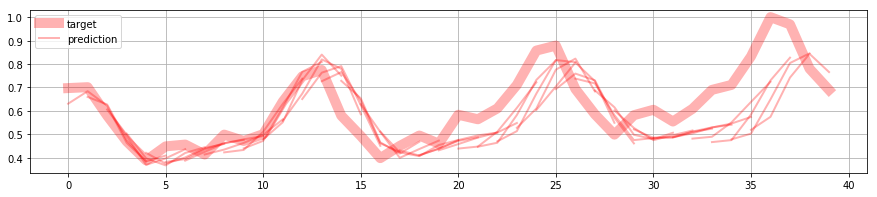

In [180]:
plt.figure(figsize=(15,3))

k = np.r_[[0.]*(yts.shape[0]+yts.shape[1]-1)]
k[:yts.shape[0]] = yts[:,0,0]
k[-yts.shape[1]+1:] = yts[-1,1:,0]
plt.plot(k, color="red", alpha=.3, lw=10, label="target")

for i in range(len(yts_preds)):
    plt.plot(range(i,i+yts.shape[1]), yts_preds[i,:,0], color="red", alpha=.3, lw=2, label="prediction" if i==0 else None)

plt.legend()
plt.grid()